# <p style="text-align: center;">Personnes et lieux cités dans la *Sylua*</p>
*Date de finalisation* : 30 juin 2023

## 0. Vérifications préalables

J'ai encodé à la main les noms de lieux et de personnes présents dans la *Sylua*. Pour autant, il est préférable de vérifier que je n'en ai pas oubliés. Pour cela, je vais faire une liste de tous les mots commençant par une majuscule qui ne sont pas en début de vers ni après un point pour établir une liste d'entitées nommées dans la *Sylua*. Cette liste ne correspondra pas exactement à ceux relevés, car parfois une personne était désigné avec un nom commun sans majuscule, mais cela permettra de fiabiliser une partie des résultats.

Je voulais initialement chercher tous les mots qui commencent par une majuscule en excluant ceux qui sont en début de ligne et ceux qui sont après un point et un espace, mais je n'ai pas réussi. Je vais donc remplacer ". " par "a" et ajouter "a" en début de chaque ligne pour exclure les mots en majuscules que je ne veux pas prendre en compte (cela rentre dans mes compétences informatiques)

In [1]:
fichier = "sylua.txt"
fichier_sortie = "sylua_mod.txt"

with open(fichier, "r") as f:
    lignes = f.readlines()

lignes_modifiees = ["a" + ligne.lstrip() if not ligne.startswith("a") else ligne for ligne in lignes]
lignes_modifiees = [ligne.replace(". ", " a") for ligne in lignes_modifiees]

with open(fichier_sortie, "w") as f:
    f.writelines(lignes_modifiees)

In [2]:
import re

fichier = "sylua_mod.txt"

# Motif de recherche pour les mots en majuscule
motif = r"\b[A-Z][a-zA-Z]*\b"

with open(fichier, "r") as f:
    # je lis le contenu du fichier ligne par ligne
    for ligne in f:
        # ensuite je demande de trouver tous les mots en majuscule dans la ligne
        mots_majuscules = re.findall(motif, ligne)
        
        for mot in mots_majuscules:
            print(mot)
            
# je n'ai pas besoin d'enregistrer sous la liste pour le moment, j'ai effectué les vérifications directement en l'affichant

Paule
Christi
Cereri
Baccho
Centaurorum
Lernam
Iambo
Theon
Genuinum
Volsius
Bacchum
Stentoreum
Verba
Helene
Iunonia
Argi
Germanica
Teutona
Bardiacis
Mauortius
Dei
Cyniphii
Scythicum
Sicaniis
Schondiacis
Germanica
Italis
Solymi
Fridricho
Roma
Christus
Christum
Auster
Stygia
Eoa
Heroica
Magnus
Macedo
Diis
Olympum
Siculi
Tyranni
Ioui
Neronem
Latonia
Apollo
Homerus
Latio
Pericle
Batauus
Musa
Paule
Spegellius
Rhenanus
Aprinam
Nouientum
Argentorati
Vitus
Vite
Rhenum
Papa
Francis
Insubribus
Anglis
Hesperiis
Turcis
Slestadii
Vito
Christi
Belial
Christo
Latina
Cato
Musas
Musas
Helicona
Sapidi
Rhenanus


## 1. Traitement des lieux

### A. Constitution d'un csv avec les coordonnées géographiques

Je veux extraire tous les lieux de mon xml Apologia_1534.xml grâce aux balises <persName>. Le nom du lieu correspond à son xml:id et les coordonnées géographiques sont à aller chercher grâce au lien dans ptr.

In [3]:
import pandas as pd
import xml.etree.ElementTree as ET

# je parse Apologia_1534.xml pour aller chercher dans son contenu
tree = ET.parse("Apologia_1534.xml")
root = tree.getroot()

# je crée des listes vides qui deviendront ensuite mes colonnes
place_names_orig = []
place_names_reg = []
l_values = []
links = []
sources = []

#je précise bien le namespace, car j'ai une erreur si je ne le fais pas correctement
namespaces = {
    "tei": "http://www.tei-c.org/ns/1.0",
    "xml": "http://www.w3.org/XML/1998/namespace"
}

#je cherche toutes les balises <l> de la Sylua
l_tags = root.iterfind(".//tei:div2[@xml:id='Sylua_poem']//tei:l", namespaces)

# dans chaque balise <l>, j'iterate pour trouver la valeur de @n (=numéro de vers)
for l_tag in l_tags:
    l_value = l_tag.get("n")

    # je cherche toutes les <placeName> dans ces <l>
    place_name_tags = l_tag.iterfind(".//tei:placeName", namespaces)

    # pour chaque <placeName>, j'iterate
    for place_name_tag in place_name_tags:
        # je prends le contenu de <placeName> (=placeName_orig)
        place_name_orig = place_name_tag.text.strip()  # j'utilise strip() pour enlever les espace

        # si @xml:id attribute est là, alors je prends la valeur de l'@ et je la mets dans la variable place_name_reg
        if "{http://www.w3.org/XML/1998/namespace}id" in place_name_tag.attrib:
            place_name_reg = place_name_tag.get("{http://www.w3.org/XML/1998/namespace}id")
        else:
            # je vais chercher dans @corresp (mon lieu est déjà apparu avant, donc pas deux fois le même xml:id)
            corresp = place_name_tag.get("corresp")

            if corresp is not None and corresp.startswith("#"):
                # je supprime "#" au début, ça me donne l'équivalent de place_name_reg
                place_name_reg = corresp[1:]
            else:
                place_name_reg = None

        # je cherche <ptr> dans le <placeName> actuel
        ptr_tag = place_name_tag.find("tei:ptr", namespaces)

        # si ptr n'est pas vide
        if ptr_tag is not None:
            # je prends le contenu de @target
            link = ptr_tag.get("target")

            # je prends le contenu de @type
            source = ptr_tag.get("type")
        else:
            link = None
            source = None

        # j'associe les données extraites aux listes crées
        place_names_orig.append(place_name_orig)
        place_names_reg.append(place_name_reg)
        l_values.append(l_value)
        links.append(link)
        sources.append(source)

# je crée avec un df
data = {
    "placeName_orig": place_names_orig,
    "placeName_reg": place_names_reg,
    "l_value": l_values,
    "link": links,
    "source": sources
}
df = pd.DataFrame(data)

# j'utilise l_value pour indexer mon df
df.set_index("l_value", inplace=True)

print(df)
df.to_csv('placeName.csv')

              placeName_orig        placeName_reg  \
l_value                                             
41                    Lernam                Lerne   
340                 Cyniphii               Cinyps   
377                Scythicum              Scythie   
413                 Sicaniis               Sicile   
416              Schondiacis          Scandinavie   
417                   Italis               Italie   
422                   Solymi            Jérusalem   
427                Palestinæ            Palestine   
432                     Roma                 Rome   
432                   Græcia                Grèce   
489                   Stygia                 Styx   
498                    Byrsæ                Byrse   
519                  Olympum               Olympe   
526                   Siculi               Sicile   
661                  Aprinam  abbaye_Ebersmunster   
662                Nouientum  abbaye_Ebersmunster   
672               Slestadium             Séles

Je n'ai pas réussi à intégrer une boucle pour traiter le cas où @xml:id n'existe pas. Je veux traiter à postériori ce cas où link et source sont vides.

In [4]:
# sur chaque ligne du df j'iterate
for index, row in df.iterrows():
    if pd.isnull(row["link"]) and pd.isnull(row["source"]):
        # je prends la vleur de placeName_reg
        place_name_reg = row["placeName_reg"]
        
        # je cherche le <placeName> qui a @xml:id correspondany
        target_place_name = root.find(".//tei:placeName[@xml:id='" + place_name_reg + "']", namespaces)
        
        if target_place_name is not None:
            # je cherche la balise <ptr> dans cette balise <placeName>
            ptr_tag = target_place_name.find("tei:ptr", namespaces)
            
            if ptr_tag is not None:
                # je prends le contenu de @target
                link = ptr_tag.get("target")
                
                # je prends le contenu de @type
                source = ptr_tag.get("type")
                
                # j'ajoute les données à mon df
                df.at[index, "link"] = link
                df.at[index, "source"] = source
                
print(df)
df.to_csv('placeName.csv')

              placeName_orig        placeName_reg  \
l_value                                             
41                    Lernam                Lerne   
340                 Cyniphii               Cinyps   
377                Scythicum              Scythie   
413                 Sicaniis               Sicile   
416              Schondiacis          Scandinavie   
417                   Italis               Italie   
422                   Solymi            Jérusalem   
427                Palestinæ            Palestine   
432                     Roma                 Rome   
432                   Græcia                Grèce   
489                   Stygia                 Styx   
498                    Byrsæ                Byrse   
519                  Olympum               Olympe   
526                   Siculi               Sicile   
661                  Aprinam  abbaye_Ebersmunster   
662                Nouientum  abbaye_Ebersmunster   
672               Slestadium             Séles

Pour Pleiades, il y avait la possibilité d'extraire les coordonnées de la page HTML, mais GeoNames utilise des renvois internes et il faut un nom d'utilisateur. Nous avons donc fait GeoNames à la main.

In [5]:
import requests
from bs4 import BeautifulSoup

# Parcours du DataFrame et extraction des informations
for index, row in df.iterrows():
    link = row['link']
    source = row['source']
    coordonnees = ''
    
    # Vérification si la source est "Pleiades"
    if source == 'Pleiades':
        # Récupération du contenu de la page web
        response = requests.get(link)
        html_content = response.content
        
        # Utilisation de BeautifulSoup pour extraire les coordonnées de la balise span
        soup = BeautifulSoup(html_content, 'html.parser')
        span_tag = soup.find('span', {'id': 'representative-point'})
        if span_tag:
            coordonnees = span_tag.text.strip()
    
    # Ajout des coordonnées extraites à la colonne "coordonnées"
    df.at[index, 'coordonnées'] = coordonnees

print(df)

              placeName_orig        placeName_reg  \
l_value                                             
41                    Lernam                Lerne   
340                 Cyniphii               Cinyps   
377                Scythicum              Scythie   
413                 Sicaniis               Sicile   
416              Schondiacis          Scandinavie   
417                   Italis               Italie   
422                   Solymi            Jérusalem   
427                Palestinæ            Palestine   
432                     Roma                 Rome   
432                   Græcia                Grèce   
489                   Stygia                 Styx   
498                    Byrsæ                Byrse   
519                  Olympum               Olympe   
526                   Siculi               Sicile   
661                  Aprinam  abbaye_Ebersmunster   
662                Nouientum  abbaye_Ebersmunster   
672               Slestadium             Séles

In [6]:
# je sépare la colonne "coordonnées" en deux colonnes "lat" et "long", puis je la supprimse
df[['lat', 'long']] = df['coordonnées'].str.split(',', expand=True).apply(lambda x: x.str.strip())
df.drop('coordonnées', axis=1, inplace=True)
print(df)

              placeName_orig        placeName_reg  \
l_value                                             
41                    Lernam                Lerne   
340                 Cyniphii               Cinyps   
377                Scythicum              Scythie   
413                 Sicaniis               Sicile   
416              Schondiacis          Scandinavie   
417                   Italis               Italie   
422                   Solymi            Jérusalem   
427                Palestinæ            Palestine   
432                     Roma                 Rome   
432                   Græcia                Grèce   
489                   Stygia                 Styx   
498                    Byrsæ                Byrse   
519                  Olympum               Olympe   
526                   Siculi               Sicile   
661                  Aprinam  abbaye_Ebersmunster   
662                Nouientum  abbaye_Ebersmunster   
672               Slestadium             Séles

In [7]:
index = df[df['placeName_reg'] == 'Scandinavie'].index[0]
df.at[index, 'lat'] = '63'
df.at[index, 'long'] = '12'

#car j'ai deux lignes
indexes = df[df['placeName_reg'] == 'abbaye_Ebersmunster'].index
df.loc[indexes, 'lat'] = '48.31123'
df.loc[indexes, 'long'] = '7.52724'

index = df[df['placeName_reg'] == 'Palestine'].index[0]
df.at[index, 'lat'] = '31.65393'
df.at[index, 'long'] ='35.10352'

#car j'ai deux lignes
indexes = df[df['placeName_reg'] == 'Sélestat'].index
df.loc[indexes, 'lat'] = '48.26195'
df.loc[indexes, 'long'] = '7.4489'

index = df[df['placeName_reg'] == 'Strasbourg'].index[0]
df.at[index, 'lat'] = '48.58392'
df.at[index, 'long'] ='7.74553'

index = df[df['placeName_reg'] == 'Saint-Ulrich'].index[0]
df.at[index, 'lat'] = '48.20291'
df.at[index, 'long'] ='7.30516'

index = df[df['placeName_reg'] == 'Benfeld'].index[0]
df.at[index, 'lat'] = '48.37062'
df.at[index, 'long'] ='7.5937'

index = df[df['placeName_reg'] == 'abbaye_Ebersmunster'].index[0]
df.at[index, 'placeName_reg'] = 'abbaye d\'Ebersmunster'

index = df[df['placeName_reg'] == 'abbaye_Ebersmunster'].index[0]
df.at[index, 'placeName_reg'] = 'abbaye d\'Ebersmunster'

index = df[df['placeName_reg'] == 'Italie'].index[0]
df = df.drop(index)

index = df[df['placeName_orig'] == 'Græcia'].index[0]
df = df.drop(index)

new_row = {'placeName_orig': 'Roma',
           'placeName_reg': 'Rome',
           'lat': '41.891775',
           'long': '12.486137',
           'link': 'https://pleiades.stoa.org/places/423025',
           'source': 'Pleiades'}
df = df.append(new_row, ignore_index=True)

print(df)
df.to_csv('placeName.csv')

         placeName_orig          placeName_reg  \
0                Lernam                  Lerne   
1              Cyniphii                 Cinyps   
2             Scythicum                Scythie   
3              Sicaniis                 Sicile   
4           Schondiacis            Scandinavie   
5                Solymi              Jérusalem   
6             Palestinæ              Palestine   
7                Stygia                   Styx   
8                 Byrsæ                  Byrse   
9               Olympum                 Olympe   
10               Siculi                 Sicile   
11              Aprinam  abbaye d'Ebersmunster   
12            Nouientum  abbaye d'Ebersmunster   
13           Slestadium               Sélestat   
14          Argentorati             Strasbourg   
15  Vlrichi Rappoldiacæ           Saint-Ulrich   
16            Benfeldum                Benfeld   
17            Slestadii               Sélestat   
18             Helicona                Hélicon   


/tmp/ipykernel_52/2193854698.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Voilà, j'ai un fichier prêt à l'emploi pour faire de la cartographie sur R!

### B. Le nombre de citations par tranche de 20 vers

Pour une raison qui m'échappe, la colonne des l_value a disparu du df et du csv, je vais donc les ajouter au moment de faire l'étude de la fréquence des citations de lieux. Il faut aussi rajouter la Grèce et l'Italie.

In [8]:
import pandas as pd

df = pd.read_csv("placeName.csv")
l_value = [41, 340, 377, 413, 416, 422, 427, 432, 489, 498, 519, 526, 661, 662, 672, 673, 685, 689, 694, 735]
df["l_value"] = l_value

nouvelle_ligne = {
    'placeName_reg': ['Grèce', 'Italie'],
    'l_value': [432, 417]
}

# j'utilise un dictio que j'intègre au df
nouvelles_donnees = pd.DataFrame(nouvelle_ligne)
df = df.append(nouvelles_donnees, ignore_index=True)

df.to_csv("placeName_l.csv", index=False)
print(df)

    Unnamed: 0       placeName_orig          placeName_reg  \
0          0.0               Lernam                  Lerne   
1          1.0             Cyniphii                 Cinyps   
2          2.0            Scythicum                Scythie   
3          3.0             Sicaniis                 Sicile   
4          4.0          Schondiacis            Scandinavie   
5          5.0               Solymi              Jérusalem   
6          6.0            Palestinæ              Palestine   
7          7.0               Stygia                   Styx   
8          8.0                Byrsæ                  Byrse   
9          9.0              Olympum                 Olympe   
10        10.0               Siculi                 Sicile   
11        11.0              Aprinam  abbaye d'Ebersmunster   
12        12.0            Nouientum  abbaye d'Ebersmunster   
13        13.0           Slestadium               Sélestat   
14        14.0          Argentorati             Strasbourg   
15      

/tmp/ipykernel_52/3077437198.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nouvelles_donnees, ignore_index=True)


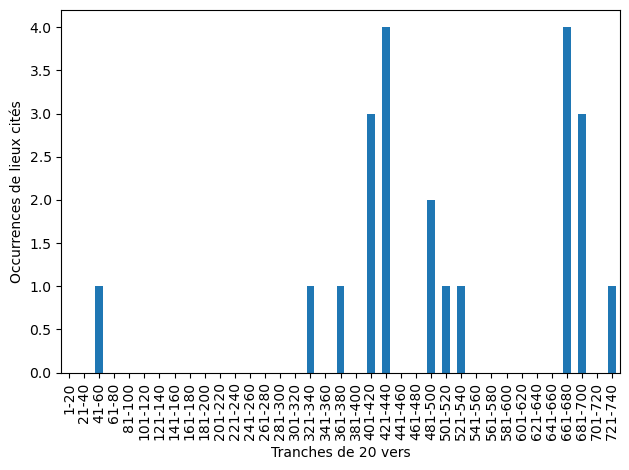

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# je charge le fichier CSV contenant les données
df = pd.read_csv('placeName_l.csv')

# je divise les valeurs de la colonne "l_value" en catégories par tranche de 20
bins = pd.cut(df['l_value'], bins=range(1, 760, 20), right=False)

# je compte le nombre d'occurrences dans chaque catégorie et trier par index (ordre croissant)
counts = pd.value_counts(bins).sort_index()

# je crée le graphique à barres
fig, ax = plt.subplots()
counts.plot(kind='bar', ax=ax)

# j'indique les labels des axes
ax.set_xlabel('Tranches de 20 vers')
ax.set_ylabel('Occurrences de lieux cités')

# Les positions et les labels des graduations
positions = range(len(counts.index))
labels = [f"{c.left}-{c.right-1}" for c in counts.index]

# je définis les graduations sur l'axe des abscisses
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation='vertical')

# j'ajuste les marges de la figure pour permettre l'affichage complet de la légende
plt.tight_layout()

plt.savefig('graphique_placeName.png')

plt.show()

## 2. Traitement des personnes

Maintenant, je veux faire aussi un relevé de tous les \<persName\> mentionnés

In [10]:
import pandas as pd
import xml.etree.ElementTree as ET

# je parse Apologia_1534.xml pour aller chercher dans son contenu
tree = ET.parse("Apologia_1534.xml")
root = tree.getroot()

# je crée des listes vides qui deviendront ensuite mes colonnes
pers_names_orig = []
pers_names_reg = []
l_values = []
typo = []

# je précise bien le namespace, car j'ai une erreur si je ne le fais pas correctement
namespaces = {
    "tei": "http://www.tei-c.org/ns/1.0",
    "xml": "http://www.w3.org/XML/1998/namespace"
}

# je cherche toutes les balises <l> de la Sylua
l_tags = root.iterfind(".//tei:div2[@xml:id='Sylua_poem']//tei:l", namespaces)

# dans chaque balise <l>, j'iterate pour trouver la valeur de @n (=numéro de vers)
for l_tag in l_tags:
    l_value = l_tag.get("n")

    # je cherche toutes les <persName> dans ces <l>
    pers_name_tags = l_tag.findall(".//tei:persName", namespaces)

    # pour chaque <persName>, j'iterate
    for pers_name_tag in pers_name_tags:
        # je vérifie si la balise a du texte
        if pers_name_tag.text is not None:
            # je prends le contenu de <persName> (=persName_orig)
            pers_name_orig = pers_name_tag.text.strip()  # j'utilise strip() pour enlever les espaces
        else:
            pers_name_orig = ""

        # si @xml:id attribute est là, alors je prends la valeur de l'@ et je la mets dans la variable pers_name_reg
        if "{http://www.w3.org/XML/1998/namespace}id" in pers_name_tag.attrib:
            pers_name_reg = pers_name_tag.get("{http://www.w3.org/XML/1998/namespace}id")
        else:
            # je vais chercher dans @corresp (mon lieu est déjà apparu avant, donc pas deux fois le même xml:id)
            corresp = pers_name_tag.get("corresp")

            if corresp is not None and corresp.startswith("#"):
                # je supprime "#" au début, ça me donne l'équivalent de place_name_reg
                pers_name_reg = corresp[1:]
            else:
                pers_name_reg = None

        pers_name_type = pers_name_tag.get("type")

        # j'associe les données extraites aux listes créées
        pers_names_orig.append(pers_name_orig)
        pers_names_reg.append(pers_name_reg)
        l_values.append(l_value)
        typo.append(pers_name_type)

# je crée le df
data = {
    "l_value": l_values,
    "persName_orig": pers_names_orig,
    "persName_reg": pers_names_reg,
    "type": typo,
}
df = pd.DataFrame(data)

print(df)
df.to_csv('persName.csv')

   l_value persName_orig persName_reg                   type
0        2         Paule         Volz                   None
1       15        Cereri        Cérès      mythologie_déesse
2       15        Baccho      Bacchus        mythologie_dieu
3       37       Eurytus      Eurytus    mythologie_centaure
4       42   Archilochus   Archiloque  historique_poète_grec
..     ...           ...          ...                    ...
66     733         Musas        Muses                   None
67     734         Musas        Muses                   None
68     734         Musas        Muses                   None
69     737        Sapidi      Sapidus     contemporain_poète
70     738      Rhenanus     Rhenanus                   None

[71 rows x 4 columns]


Remplissons les cases vides à partir des infos déjà dans le tableau.

In [11]:
# sur chaque ligne du df j'iterate
for index, row in df.iterrows():
    if pd.isnull(row["type"]):
        # je prends la valeur de persName_reg
        pers_name_reg = row["persName_reg"]
        
        # je cherche le <persName> qui a @xml:id correspondany
        target_pers_name = root.find(".//tei:persName[@xml:id='" + pers_name_reg + "']", namespaces)
        
        if target_pers_name is not None:
            # je cherche la balise <ptr> dans cette balise <placeName>
            type_persName = target_pers_name.get("type")
                
            # j'ajoute les données à mon df
            df.at[index, "type"] = type_persName

Je nettoie les données et j'enregistre

In [12]:
index = df[df['persName_reg'] == 'Sapidus'].index[0]    # nécessaire, car Sapidus détaillé ailleurs que Sylua
df.at[index, 'type'] = 'contemporain_poète'

index = df[df['persName_reg'] == 'Scipion_Emilien'].index[0]    # nécessaire, car balise <placeName> au sein de la balise <persName>, contenu pas retrouvé
df.at[index, 'persName_orig'] = 'Byrsæ subactor'

df['type'] = df['type'].str.replace('_', ' ')
df['persName_reg'] = df['persName_reg'].str.replace('_', ' ')


print(df)
df.to_csv('persName.csv')

   l_value persName_orig persName_reg                   type
0        2         Paule         Volz       contemporain ami
1       15        Cereri        Cérès      mythologie déesse
2       15        Baccho      Bacchus        mythologie dieu
3       37       Eurytus      Eurytus    mythologie centaure
4       42   Archilochus   Archiloque  historique poète grec
..     ...           ...          ...                    ...
66     733         Musas        Muses      mythologie déesse
67     734         Musas        Muses      mythologie déesse
68     734         Musas        Muses      mythologie déesse
69     737        Sapidi      Sapidus     contemporain poète
70     738      Rhenanus     Rhenanus       contemporain ami

[71 rows x 4 columns]


## 3. Analyse des personnes

### A. La typologie

In [13]:
import pandas as pd

df = pd.read_csv('persName.csv')

# Extraire le texte de la colonne "type" et le mettre en une seule chaîne de caractères
type_text = ' '.join(df['type'].dropna())

# Convertir le texte en une liste de mots
words = type_text.split()

# Compter le nombre d'occurrences de chaque mot
word_counts = pd.Series(words).value_counts()

# Afficher le tableau récapitulatif des occurrences des mots
print(word_counts)

mythologie      28
contemporain    17
dieu            16
historique      12
ami             12
déesse           8
religion         8
peuple           7
homme            6
poète            5
grec             5
romain           3
empereur         3
géant            2
dieux            2
femme            2
pape             1
muse             1
auteur           1
mère             1
Sicile           1
tyran            1
centaure         1
grecque          1
Macédoine        1
Enfers           1
nocher           1
vent             1
allemand         1
diable           1
dtype: int64


### B. Le nombre de citations par tranche de 20 vers

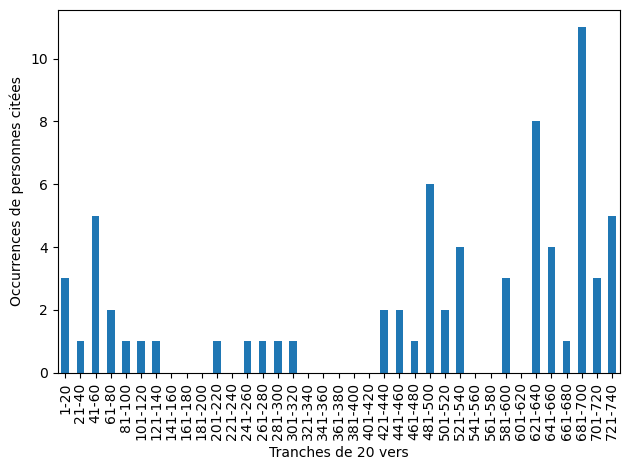

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# je charge le fichier CSV contenant les données
df = pd.read_csv('persName.csv')

# je divise les valeurs de la colonne "l_value" en catégories par tranche de 20
bins = pd.cut(df['l_value'], bins=range(1, 760, 20), right=False)

# je compte le nombre d'occurrences dans chaque catégorie et trier par index (ordre croissant)
counts = pd.value_counts(bins).sort_index()

# je crée le graphique à barres
fig, ax = plt.subplots()
counts.plot(kind='bar', ax=ax)

# j'indique les labels des axes
ax.set_xlabel('Tranches de 20 vers')
ax.set_ylabel('Occurrences de personnes citées')

# Les positions et les labels des graduations
positions = range(len(counts.index))
labels = [f"{c.left}-{c.right-1}" for c in counts.index]

# je définis les graduations sur l'axe des abscisses
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation='vertical')

# j'ajuste les marges de la figure pour permettre l'affichage complet de la légende
plt.tight_layout()

plt.savefig('graphique.png')

plt.show()

### C. Les personnes récurrentes

In [17]:
import pandas as pd
df = pd.read_csv("persName.csv")

# je compte le nombre d'occurrences de chaque chaîne de caractères identique dans persName_reg
occurrences = df['persName_reg'].value_counts().reset_index()
occurrences.columns = ['persName_reg', 'Count']

# mais je veux conserver le contenu de la colonne "Type"
occurrences = pd.merge(occurrences, df[['persName_reg', 'type']], on='persName_reg', how='left')

# du coup, je dois supprimer les doublons
occurrences = occurrences.drop_duplicates()

occurrences = occurrences.reset_index(drop=True)
print(occurrences)
occurrences.to_csv('pers_Name_count.csv', index=False)

          persName_reg  Count                          type
0                 Volz      5              contemporain ami
1                Muses      5             mythologie déesse
2                Vitus      4              contemporain ami
3               Phébus      4               mythologie dieu
4               Christ      4                 religion dieu
5                 Dieu      2                 religion dieu
6              Sapidus      2            contemporain poète
7             Rhenanus      2              contemporain ami
8              Bacchus      2               mythologie dieu
9             Milanais      1                        peuple
10               Turcs      1                        peuple
11               Néron      1    historique empereur romain
12               Diane      1             mythologie déesse
13              Latone      1         mythologie mère dieux
14              Bélial      1               religion diable
15              Homère      1           

In [18]:
import pandas as pd
df = pd.read_csv("persName.csv")
occurrences = df['persName_reg'].value_counts()
print(occurrences)
occurrences.to_csv('pers_Name_count.csv')

Volz                  5
Muses                 5
Vitus                 4
Phébus                4
Christ                4
Dieu                  2
Sapidus               2
Rhenanus              2
Bacchus               2
Milanais              1
Turcs                 1
Néron                 1
Diane                 1
Latone                1
Bélial                1
Homère                1
Périclès              1
Erasme                1
Français              1
Muse                  1
Espagnols             1
Spiegel               1
Denys                 1
Charles Quint         1
Anglais               1
Clément VII           1
Jupiter               1
dieux                 1
Altas                 1
Cérès                 1
Eurytus               1
Archiloque            1
Néobulé               1
Lycambès              1
Théon                 1
Stentor               1
Hélène                1
Junon                 1
Argus                 1
Teutons               1
Mars                  1
soleil          

In [19]:
len(occurrences)

50

In [20]:
total_personnes = len(df['persName_reg'])

personnes_une_seule_fois = (occurrences == 1).sum()
pourcentage_une_seule_fois = (personnes_une_seule_fois / total_personnes) * 100

personnes_plus_de_deux = occurrences[occurrences > 1]
occurrences_plus_de_deux = personnes_plus_de_deux.sum()
total_occurrences = occurrences.sum()
pourcentage_plus_de_deux = (occurrences_plus_de_deux / total_occurrences) * 100

print("Pourcentage de personnes citées une seule fois:", pourcentage_une_seule_fois)
print("Pourcentage de personnes citées plus de deux fois:", pourcentage_plus_de_deux)

Pourcentage de personnes citées une seule fois: 57.74647887323944
Pourcentage de personnes citées plus de deux fois: 42.25352112676056


In [23]:
count_contemporain = df['type'].str.contains("contemporain", na=False).sum()
print("Nombre de fois que la colonne 'Type' contient 'contemporain (on retire 1 pour le pape en type 2):", count_contemporain)
count_religion = df['type'].str.contains("religion", na=False).sum()
print("Nombre de fois que la colonne 'Type' contient 'religion':", count_religion)
count_historique = df['type'].str.contains("historique", na=False).sum()
print("Nombre de fois que la colonne 'Type' contient 'historique':", count_historique)
count_mythologie = df['type'].str.contains("mythologie", na=False).sum()
print("Nombre de fois que la colonne 'Type' contient 'mythologie':", count_mythologie)
count_peuple = df['type'].str.contains("peuple", na=False).sum()
print("Nombre de fois que la colonne 'Type' contient 'peuple':", count_peuple)

Nombre de fois que la colonne 'Type' contient 'contemporain (on retire 1 pour le pape en type 2): 17
Nombre de fois que la colonne 'Type' contient 'religion': 8
Nombre de fois que la colonne 'Type' contient 'historique': 12
Nombre de fois que la colonne 'Type' contient 'mythologie': 28
Nombre de fois que la colonne 'Type' contient 'peuple': 7
